<a href="https://colab.research.google.com/github/DanieleAngioni97/AI_Project/blob/main/notebook/iCubeProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install secml

     |████████████████████████████████| 460kB 20.5MB/s 


# **Da riadattare con il CIFAR dal model.zoo**

Files already downloaded and verified
Files already downloaded and verified
  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


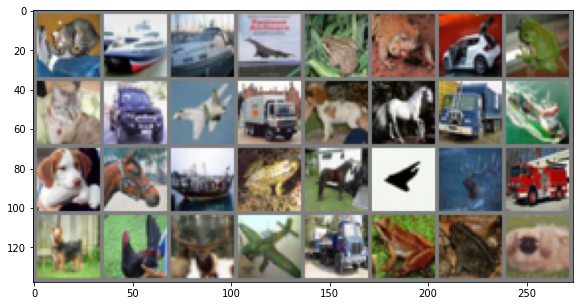

In [5]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

batch_size = 32
clf_path = "/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/cifar_model.gz"

# set CPU or GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = (img / 2 + 0.5)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print labels for the first 8 images
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# show images
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))

# **Sezioni provvisorie per salvare il modello CClassifierPyTorch**

In [7]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict


class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = out_channels
    return nn.Sequential(*layers)


def cifar10(n_channel=128, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel,
           'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(
            'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth')
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

In [6]:
correct = 0
total = 0

model = cifar10(pretrained=True).to(device)
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91.82


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from secml.ml.features.normalization import CNormalizerMeanStd

transform = CNormalizerMeanStd(mean=(0.5,0.5,0.5), 
                              std=(0.5,0.5,0.5), 
                              with_std=True)


from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=model,
                         loss=criterion,
                         optimizer=optimizer,
                         preprocess = transform,
                         pretrained=True,
                         epochs=100,
                         batch_size=64,
                         input_shape=(3, 32, 32),
                         random_state=0)



clf.save(path=clf_path)

# **Load CClassifierPyTorch pretrained on CIFAR10**

In [8]:
from secml.core import CCreator
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10

loader = CDataLoaderCIFAR10()
tr , ts = loader.load()

# Normalize the data
tr.X /= 255
ts.X /= 255

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

clf_path = "/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/cifar_model.gz"
cifar_clf = CCreator().load(path=clf_path)

y_pred = cifar_clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc = metric.performance_score(ts.Y, y_pred)

print("Model Accuracy: {}%".format(acc*100))

Model Accuracy: 92.75%


# **Load keras model of autoencoder**

In [9]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import numpy as np
from keras.models import load_model


def create_autoencoder():
 
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------
    #                       DEFINE AUTOENCODER ARCHITECTURE
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------

    input_img = Input(shape=(32, 32, 3))
 
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img) #(5, 5, 3, 32)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x) #16x16
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 
    # at this point the representation is (4, 4, 128)
 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #16x16
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #32x32
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
    autoencoder = Model(input_img, decoded)
    
    return autoencoder

path_autoencoders = "/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/"
model_name = "autoencoderCifar_Test.h5"
autoencoder = create_autoencoder()
autoencoder.load_weights(path_autoencoders + model_name)

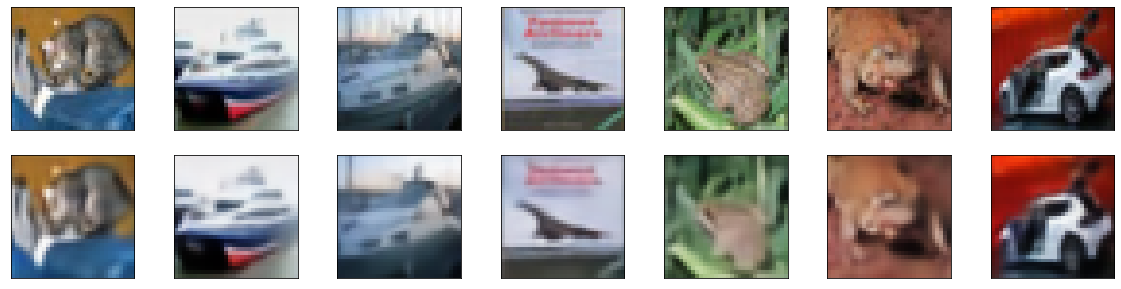

In [11]:
from keras.models import load_model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# images, _ = iter(testloader).next()
# images = np.transpose((images / 2 + 0.5).numpy(), (0, 2, 3, 1))

images = ts.X[:batch_size, :]
images = images.tondarray().reshape((batch_size, 3, 32, 32)).transpose((0, 2, 3, 1))

path_autoencoders = "/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/"
model_name = "autoencoderCifar_100.h5"
autoencoder = create_autoencoder()
autoencoder.load_weights(path_autoencoders + model_name)

def plot_AE_results(dataset, autoencoder):
    n = 7 #images to be visualized    
    bias = 0 #starting index from the test set for the visualization
    plt.figure(figsize=(20, 5))

    decoded_imgs = autoencoder.predict(dataset[bias:bias+n])
    
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dataset[i+bias])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_AE_results(images, autoencoder)

# **Build the same architecture in PyTorch**

Before loading keras weight


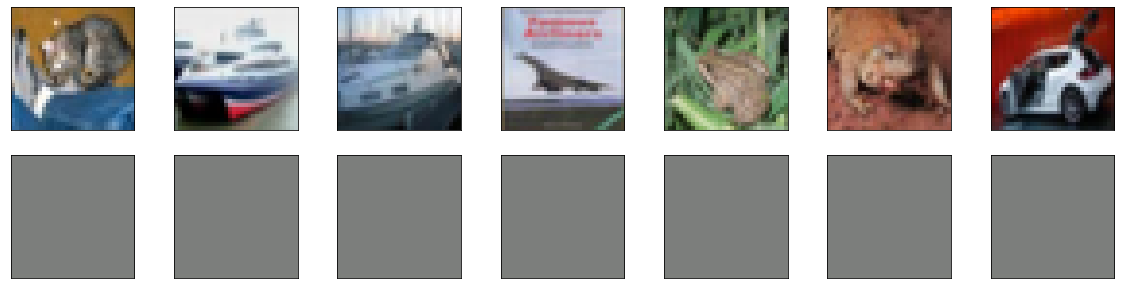

After loading keras weight


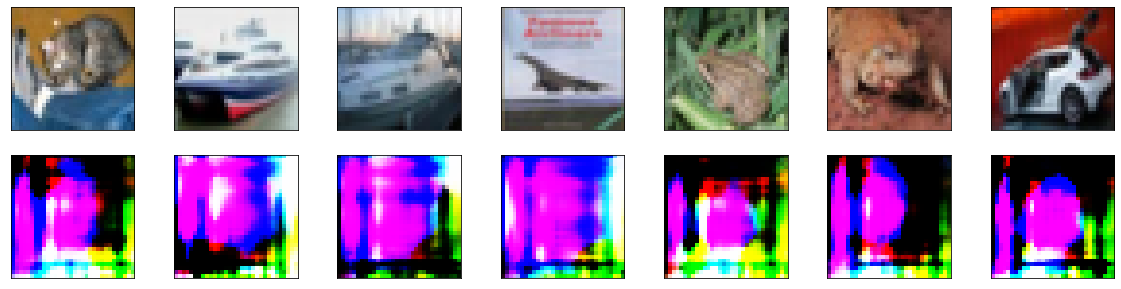

In [15]:
import torch.nn as nn
#import Conv2d, AvgPool2d, Upsample, Sequential, ReLU

class Cifar_AE(nn.Module):
    def __init__(self):
        super(Cifar_AE, self).__init__()
        """
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img) #(5, 5, 3, 32)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = AveragePooling2D((2, 2), padding='same')(x) #16x16

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = AveragePooling2D((2, 2), padding='same')(x)   #8x8

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
        encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

        # at this point the representation is (4, 4, 128)
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        """
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x) #8x8

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) #16x16

        x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
        x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) #32x32

        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        """
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded_x = self.encoder(x)
        decoded_x = self.decoder(encoded_x)

        return encoded_x, decoded_x

    def load_keras_weights(self, autoencoder_keras):
        w_keras = autoencoder_keras.get_weights()

        for stack in [self.encoder, self.decoder]:
            for i, layer in enumerate(stack):
                if isinstance(layer, nn.Conv2d):
                    new_weight = w_keras.pop(0)
                    new_bias = w_keras.pop(0)

                    layer.weight.data = torch.from_numpy(np.transpose(new_weight))
                    layer.bias.data = torch.from_numpy(np.transpose(new_bias))

                    # print("features :{}\nw_shape = {}\nb_shape = {}"
                    # .format(i, layer.weight.data.shape, layer.bias.data.shape))
                    # print("\n")

    def evaluate_batch(self, testloader):
        model.eval()
        images, _ = iter(testloader).next()
        images = ((images / 2) + 0.5)

        with torch.no_grad():    
            _, output = model(images[:7])

        images = np.transpose(images.numpy(), (0, 2, 3, 1))
        output = np.transpose(output.numpy(), (0, 2, 3, 1))

        plt.figure(figsize=(20, 5))
        n = output.shape[0]

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(images[i])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(output[i])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

model = Cifar_AE()
print("Before loading keras weight")
model.evaluate_batch(testloader)
model.load_keras_weights(autoencoder)
print("After loading keras weight")
model.evaluate_batch(testloader)